<a href="https://colab.research.google.com/github/holiday-scott/HackerNewsPostAnalysis/blob/main/Exploring_Hacker_News_Posts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Hacker News Posts

[This data set](https://www.kaggle.com/hacker-news/hacker-news-posts) is Hacker News posts from the last 12 months (up to September 26 2016). 

The original data has been reduced to remove any posts which did not receive comments.

- **id**: The unique identifier from Hacker News for the post
- **title**: The title of the post
- **url**: The URL that the posts links to, if the post has a URL
- **num_points**: The number of points the post acquired, calculated as the total number of upvotes minus the total number of downvotes
- **num_comments**: The number of comments that were made on the post
- **author**: The username of the person who submitted the post
- **created_at**: The date and time at which the post was submitted

## Problem - Max Engagement?
What kind of post should be published and when should it be published to get maximum engagement?

## The Solution
1. Filter the post data to see which kinds of post occur most often.
2. Look at the number of comments and 'up votes' for each category to see which kind of post gets the most engagement.
  - From here, focus on this popular post type.
3. Look at the hour the posts were made and find:
  - Which hour do people post most content?
  - Which hour gets the most comments?
  - Which hour gets the most 'up votes'?
4. A recommendation can now be made.

# Open and Prepare the Data
This data does not need cleaning.


In [2]:
# Mount Google.
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
#drive.flush_and_unmount()

# Load reader modules
from csv import reader

# Find out where the data is.
#!ls "gdrive/MyDrive/Colab Notebooks/p2/"

### Open Hacker News Dataset ###
opened_file = open('gdrive/MyDrive/Colab Notebooks/p2/HN_posts_year_to_Sep_26_2016.csv')
read_file = reader(opened_file)
hn_dataset = list(read_file)
header = hn_dataset[0]
hn = hn_dataset[1:]

Mounted at /content/gdrive


## Inside the Data
The data has a header row, so we'll make two lists:
- hn - the whole dataset, except the header row
- header - the header row

In [3]:
print(header)

for row in hn[0:4]:
  print(row)
  print("\n")

['id', 'title', 'url', 'num_points', 'num_comments', 'author', 'created_at']
['12579008', 'You have two days to comment if you want stem cells to be classified as your own', 'http://www.regulations.gov/document?D=FDA-2015-D-3719-0018', '1', '0', 'altstar', '9/26/2016 3:26']


['12579005', 'SQLAR  the SQLite Archiver', 'https://www.sqlite.org/sqlar/doc/trunk/README.md', '1', '0', 'blacksqr', '9/26/2016 3:24']


['12578997', 'What if we just printed a flatscreen television on the side of our boxes?', 'https://medium.com/vanmoof/our-secrets-out-f21c1f03fdc8#.ietxmez43', '1', '0', 'pavel_lishin', '9/26/2016 3:19']


['12578989', 'algorithmic music', 'http://cacm.acm.org/magazines/2011/7/109891-algorithmic-composition/fulltext', '1', '0', 'poindontcare', '9/26/2016 3:16']




## 1. Filter the post data to see which kinds of post occur most often

Two of the most popular kinds of post at "Ask HN" and "Show HN" posts. So popular, they are the only type on the super-minimal banner.

image.png

Maximum engagement means:
- What are people posting most often? From this is might follow that this is what engages the most.
- How many comments does each post type get?
- How many upvotes does each post type get? 

### What types of post are most common?
I used the lower() function to make sure case doesn't become a filter. Then the .startswith() method to create a filter resulting in three lists of lists:

1. ask_posts
2. show_posts
3. other_posts

These lists will form the foundation of much of the following analysis.

In [5]:
ask_posts = []
show_posts = []
other_posts = []

for row in hn:
  title = row[1]
  if title.lower().startswith("ask hn"):
    ask_posts.append(row)
  elif title.lower().startswith("show hn"):
    show_posts.append(row)
  else:
    other_posts.append(row)

print("Total 'Ask HN' posts:", len(ask_posts))
print("Total 'Show HN' posts:", len(show_posts))
print("Total 'Other' posts:", len(other_posts))


Total 'Ask HN' posts: 9139
Total 'Show HN' posts: 10158
Total 'Other' posts: 273822


#### The Result
"Ask HN" and "Show HN" posts are fairly evenly split with about 10k each. 

Engagement will come down to comments and upvotes.

## 3. Average Comments & Upvotes
A better measure of popularity might be looking at which kind of post has the great number of comments and upvotes.

An average is good enough for this purpose.



In [10]:
# Loop through the Ask HN list of lists
# Sum comments (index 4)
ask_comments = 0
ask_upvotes = 0
for row in ask_posts:
  ask_comments += int(row[4])
  ask_upvotes += int(row[3])

# Loop through the Show HN list of lists
# Sum comments (index 4)
show_comments = 0
show_upvotes = 0
for row in show_posts:
  show_comments += int(row[4])
  show_upvotes += int(row[3])

# The length of the list is the number of posts.
print("Average comments on Ask HN posts:", round(ask_comments/len(ask_posts)))
print("Average upvotes on Ask HN posts:", round(ask_upvotes/len(ask_posts)))
print("Average comments on Show HN posts:", round(show_comments/len(show_posts)))
print("Average upvotes on Show HN posts:", round(show_upvotes/len(show_posts)))

Average comments on Ask HN posts: 10
Average upvotes on Ask HN posts: 11
Average comments on Show HN posts: 5
Average upvotes on Show HN posts: 15


### Analysis
Comments are a better measure of engagement because it takes time to do. Therefore, to override a high comment count, another type would need a very high number of upvotes.

Ask HN posts get double the comments Show HN posts get. Show HN posts get more upvotes, but not by a very significant margin.

Therefore, Ask HN posts get better engagement.



# 3. Time Analysis
Is there an optimal time to publish an Ask HN post?

I will segment the dataset into hour buckets and look at the quanity of comments and upvotes for each time delta.

## Prepare the Times
The date column contains "9/26/2016 3:16" which needs to be reformated into a datetime object.

In [14]:
# Import the datetime module as an alias.
# dt is the alias for the module
# dt.datetime() is the class itself
import datetime as dt

# Convert the 'created at' column in the dataset to a datetime type.
# Using only the ask_posts list.
for row in ask_posts:
  created_str = row[-1]
  created_dt = dt.datetime.strptime(created_str, "%m/%d/%Y %H:%M")
  row[-1] = created_dt

We can now see that the created at column is the datetime type

In [15]:
print(ask_posts[0:1])


[['12578908', 'Ask HN: What TLD do you use for local development?', '', '4', '7', 'Sevrene', datetime.datetime(2016, 9, 26, 2, 53)]]


## Time Bins
There are three things we need to track for Ask HN posts:
1. Total posts per hour.
2. Total comments per hour.
3. Total upvotes per hour.

**Classes** can help make this code more robust and future-proof in the instance HN starts using a different datetime format or we want to change the delta of the bin.

I will therefore:
1. Create a class which:
  - pulls out the required delta from the dataset.
  - creates a frequency dictionary for that bin delta.


In [158]:
freq_pph = {}
freq_cph = {}
freq_uph = {}

# Creates a binned frequency table:
# - key is bin_minutes (size of bin in minutes).
# - value is freq_value which sums/counts the number of things in that column. 
class BinFreq:
  def __init__(self, dataset, bin_minutes, freq_value, dict_name):
    self.dataset = dataset
    self.bin_minutes = bin_minutes
    self.freq_value = freq_value
    self.dict_name = dict_name
    #self.freq_posts_per_hour = freq_posts_per_hour

  def make_table(self):
    # Sets bin size
    # Counts how of posts in that timedelta
    if (self.bin_minutes == 60) and (self.freq_value == "None"):
      for post in self.dataset:
        hour_dt = post[-1]
        hour_str = hour_dt.strftime("%H")
        if hour_str in self.dict_name:
           self.dict_name[hour_str] += 1
        else:
           self.dict_name[hour_str] = 1
    # Sets bins size
    # Sums the values of a given index/column
    if (self.bin_minutes == 60) and (self.freq_value != "None"):
      for post in self.dataset:
        hour_dt = post[-1]
        hour_str = hour_dt.strftime("%H")
        if hour_str in self.dict_name:
          self.dict_name[hour_str] += int(post[self.freq_value])
        else:
          self.dict_name[hour_str] = int(post[self.freq_value])
    return self.dict_name


The class below sorts the dictionary into ascending time order so we can plot it properly.

In [168]:
sorted_dict = {}

class SortDict:
  def __init__(self, sort_this_dict, desc):
    self.sort_this_dict = sort_this_dict
    self.desc = desc

  # Sorts dictionary in ascending or descending order.
  def sort_dict(self):
    dict_items = self.sort_this_dict.items()
    sorted_tuple = sorted(dict_items)
    sorted_dict = dict(sorted_tuple)
    return sorted_dict 


Below I instantiate all the classess and get them ready for plotting.

In [169]:
## PPH - Posts Per Hour
# Instantiate the class for post frequency.
pph = BinFreq(ask_posts, 60, "None", freq_pph)
pph_dict = pph.make_table()

# Sort the dictionary that is returned.
spph = SortDict(pph_dict, desc=True)
spph_dict = spph.sort_dict()
print(spph_dict)

## CPH - Comments Per Hour
# Instantiate the class for comment frequency.
cph = BinFreq(ask_posts, 60, 4, freq_cph)
cph_dict = cph.make_table()

# Sort the dictionary that is returned.
scph = SortDict(cph_dict, desc=True)
scph_dict = scph.sort_dict()
print(scph_dict)

## UPH - Upvotes Per Hour
# Instantiate the class for upvote frequency.
uph = BinFreq(ask_posts, 60, 3, freq_uph)
uph_dict = uph.make_table()

# Sort the dictionary that is returned.
suph = SortDict(uph_dict, desc=True)
suph_dict = suph.sort_dict()
print(suph_dict)

{'00': 1806, '01': 1692, '02': 1614, '03': 1626, '04': 1458, '05': 1254, '06': 1404, '07': 1356, '08': 1542, '09': 1332, '10': 1692, '11': 1872, '12': 2052, '13': 2664, '14': 3078, '15': 3876, '16': 3474, '17': 3522, '18': 3684, '19': 3312, '20': 3060, '21': 3108, '22': 2298, '23': 2058}
{'00': 9108, '01': 8356, '02': 11984, '03': 8616, '04': 9440, '05': 7352, '06': 6348, '07': 6340, '08': 9448, '09': 5908, '10': 12052, '11': 11188, '12': 16936, '13': 28980, '14': 19888, '15': 74100, '16': 17864, '17': 22188, '18': 19508, '19': 15816, '20': 17848, '21': 18000, '22': 13488, '23': 9188}
{'00': 11340, '01': 10648, '02': 11776, '03': 10156, '04': 10600, '05': 8184, '06': 8120, '07': 8160, '08': 10976, '09': 7052, '10': 15156, '11': 11424, '12': 18572, '13': 31848, '14': 21560, '15': 55912, '16': 23880, '17': 28620, '18': 27400, '19': 19128, '20': 17964, '21': 20168, '22': 14404, '23': 10464}


## Plotting the Data
A bar chart is the best choice when using timedelta binned data.


<BarContainer object of 24 artists>

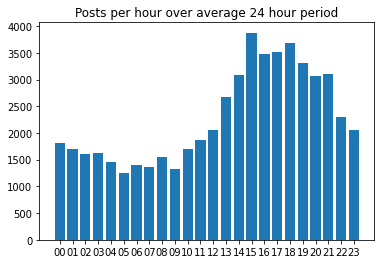

In [185]:
import matplotlib

spph_dict_values = spph_dict.values()
spph_dict_keys = spph_dict.keys()
matplotlib.pyplot.title("Posts per hour over average 24 hour period")
matplotlib.pyplot.bar(spph_dict_keys, spph_dict_values)

<BarContainer object of 24 artists>

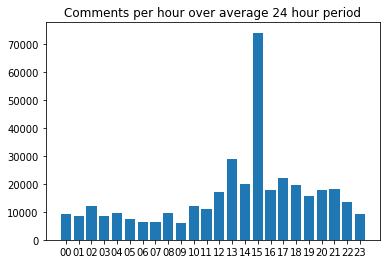

In [186]:
scph_dict_values = scph_dict.values()
scph_dict_keys = scph_dict.keys()
matplotlib.pyplot.title("Comments per hour over average 24 hour period")
matplotlib.pyplot.bar(scph_dict_keys, scph_dict_values)

<BarContainer object of 24 artists>

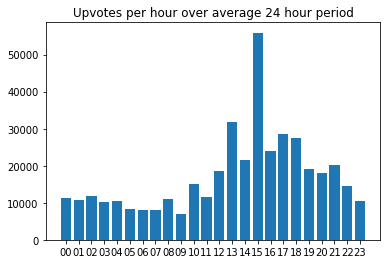

In [187]:
suph_dict_values = suph_dict.values()
suph_dict_keys = suph_dict.keys()
matplotlib.pyplot.title("Upvotes per hour over average 24 hour period")
matplotlib.pyplot.bar(suph_dict_keys, suph_dict_values)

# Solution
It is very clear that for maximum engagement, you should post an Ask HN post at 15:00.